In [1]:
import networkx as nx
import matplotlib.pyplot as plt

import sys
sys.path.append('..')

from sbm import fast_sbm

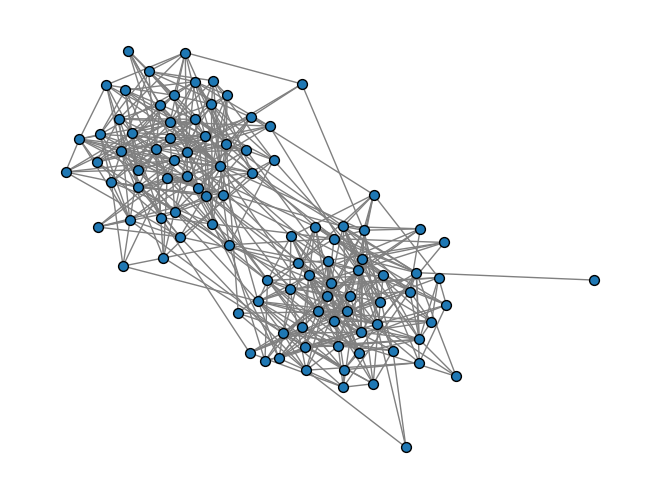

In [11]:
# Parameters for the SBM
c_in = 10  # Average number of within-community connections
c_out = 1  # Average number of between-community connections
n = 100  # Total number of nodes

# Call the function to create the graph
G = fast_sbm(c_in, c_out, n)

# Drawing the graph
nx.draw(G, node_size=50, edge_color='gray', edgecolors='black')
plt.show()